In [346]:
import cv2 as cv
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.fftpack import dct
from skimage.transform import rescale

In [356]:
images_path = 'att_faces'

In [357]:
images = []
labels = []
for label, dir_name in enumerate(sorted(os.listdir(images_path))):
    dir_path = os.path.join(images_path, dir_name)
    for image_name in os.listdir(dir_path):
        image_path = os.path.join(dir_path, image_name)
        img = cv.imread(image_path, 0)
        images.append(img)
        labels.append(label)

In [343]:
class BrightnessClassifier:
    """
        Классификатор на основе гистограммы яркости
    """
    def __init__(self, hist_size=256):
        self.hist_size = hist_size
    
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.train_histograms = []
        for train_image in self.X_train:
            train_hist = cv.calcHist([train_image], [0], None, [self.hist_size],[0,256])
            self.train_histograms.append(train_hist)
    
    def predict(self, test_images):
        predictions = []
        for test_image in test_images:
            distances = []
            test_hist = cv.calcHist([test_image], [0], None, [self.hist_size],[0,256])
            for train_hist in self.train_histograms:
                dist = np.linalg.norm(test_hist - train_hist)
                distances.append(dist)
            prediction = self.y_train[np.argmin(distances)]
            predictions.append(prediction)
            
        return np.array(predictions)
            

In [516]:
class DFTClassifier:
    """
        Классификатор на основе дискретного преобразования Фурье
    """
    def __init__(self, size=1.0):
        self.size = size
    
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.max_row = int(X_train[0].shape[0]*self.size)
        self.max_column = int(X_train[0].shape[1]*self.size)
        self.train_dfts = []
        for train_image in self.X_train:
            train_dft = np.fft.fft2(train_image)
            train_dft = np.fft.fftshift(train_dft)
            train_dft = 20*np.log(np.abs(train_dft))
            train_dft = train_dft[:self.max_row, :self.max_column]    
            self.train_dfts.append(train_dft)
    
    def predict(self, test_images):
        predictions = []
        for test_image in test_images:
            distances = []
            test_dft = np.fft.fft2(test_image)
            test_dft = np.fft.fftshift(test_dft)
            test_dft = 20*np.log(np.abs(test_dft))
            test_dft = test_dft[:self.max_row, :self.max_column]
            for train_dft in self.train_dfts:
                dist = np.linalg.norm(test_dft.ravel() - train_dft.ravel())
                distances.append(dist)
            prediction = self.y_train[np.argmin(distances)]
            predictions.append(prediction)     
            
        return np.array(predictions)

In [448]:
class DCTClassifier:
    """
        Классификатор на основе дискретного косинусного преобразования
        @param: float size: Использует прямоугольник размером size*row и size*columns от всего изображения
    """
    def __init__(self, size=1.0):
        self.size = size
    
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.max_row = int(X_train[0].shape[0]*self.size)
        self.max_column = int(X_train[0].shape[1]*self.size)
        self.train_dcts = []
        for train_image in self.X_train:
            train_dct = dct(dct(train_image.T, norm='ortho').T, norm='ortho')
            train_dct = train_dct[:self.max_row, :self.max_column]
            self.train_dcts.append(train_dct)    
    
    def predict(self, test_images):
        predictions = []
        for test_image in test_images:
            distances = []
            test_dct = dct(dct(test_image.T, norm='ortho').T, norm='ortho')
            test_dct = test_dct[:self.max_row, :self.max_column]
            for train_dct in self.train_dcts:
                dist = np.linalg.norm(train_dct.ravel() - test_dct.ravel())
                distances.append(dist)
            prediction = self.y_train[np.argmin(distances)]
            predictions.append(prediction)
        
        return np.array(predictions)

In [319]:
class ScaleClassifier:
    """
        Классификатор на основе масштабирования
        @param array-like sizes: Представляет собой массив масштабов
    """
    def __init__(self, sizes=[1.0]):
        self.sizes = sizes
    
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.train_rescaled_imgs = []
        for train_image in self.X_train:
            rescaled = self.get_rescaled_imgs(train_image)
            self.train_rescaled_imgs.append(rescaled)
    
    def get_rescaled_imgs(self, img):
        rescaled_imgs = []
        for size in self.sizes:   
            rescaled_img = rescale(img, size, mode='constant', anti_aliasing=False, multichannel=False)
            rescaled_imgs.append(rescaled_img)
        return rescaled_imgs       
    
    def get_avg_distance(self, rescaled_img1, rescaled_img2):
        total_dist = 0
        for i in range(len(self.sizes)):
            total_dist += np.linalg.norm(rescaled_img1[i].ravel() - rescaled_img2[i].ravel())
        
        return total_dist / len(self.sizes)
    
    def predict(self, test_images):
        predictions = []
        for test_image in test_images:
            distances = []
            test_rescaled_img = self.get_rescaled_imgs(test_image)
            for train_rescaled_img in self.train_rescaled_imgs:
                dist = self.get_avg_distance(test_rescaled_img, train_rescaled_img)
                distances.append(dist)
            prediction = self.y_train[np.argmin(distances)]
            predictions.append(prediction)
            
        return np.array(predictions)   

In [332]:
class GradientClassifier:
    """
        Классификатор на основе градиента
        @param: int ksize: Размер ядра
    """
    def __init__(self, ksize=-1):
        self.ksize = ksize
    
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train= y_train
        self.train_gradients = []
        for train_image in self.X_train:
            train_grad = cv.Sobel(train_image, cv.CV_64F, 0, 1, ksize=self.ksize)
            self.train_gradients.append(train_grad)
    
    def predict(self, test_images):
        predictions = []
        for test_image in test_images:
            distances = []
            test_grad = cv.Sobel(test_image, cv.CV_64F, 0, 1, ksize=self.ksize)
            for train_grad in self.train_gradients:
                dist = np.linalg.norm(test_grad.ravel() - train_grad.ravel())
                distances.append(dist)
            prediction = self.y_train[np.argmin(distances)]
            predictions.append(prediction)
        
        return np.array(predictions)

In [263]:
def accuracy_score(y_pred, y_test):
    return sum(y_pred == y_test) / len(y_test)

In [362]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=len(np.unique(labels)), 
                                                    random_state=25, stratify=labels)

# Тестирование на обучающей выборке

## Гистограмма яркости

In [295]:
brightness_clf = BrightnessClassifier()

In [296]:
brightness_clf.fit(X_train, y_train)

In [297]:
%%time
y_pred = brightness_clf.predict(X_train)

CPU times: user 176 ms, sys: 194 µs, total: 177 ms
Wall time: 174 ms


In [298]:
accuracy_score(y_pred, y_train)

1.0

## Дискретное преобразование Фурье

In [304]:
dft_clf = DFTClassifier()

In [305]:
dft_clf.fit(X_train, y_train)

In [306]:
%%time
y_pred = dft_clf.predict(X_train)

CPU times: user 30.3 s, sys: 35.1 s, total: 1min 5s
Wall time: 16.6 s


In [307]:
accuracy_score(y_pred, y_train)

1.0

## Дискретное косинусное преобразование

In [312]:
dct_clf = DCTClassifier()

In [313]:
dct_clf.fit(X_train, y_train)

In [314]:
%%time
y_pred = dct_clf.predict(X_train)

CPU times: user 6.87 s, sys: 7.02 s, total: 13.9 s
Wall time: 3.53 s


In [315]:
accuracy_score(y_pred, y_train)

1.0

## Масштабирование

In [320]:
scale_clf = ScaleClassifier(sizes=[1.0, 0.9, 0.8, 0.5])

In [321]:
%%time
scale_clf.fit(X_train, y_train)

CPU times: user 3.11 s, sys: 3.01 s, total: 6.13 s
Wall time: 2.05 s


In [322]:
%%time
y_pred = scale_clf.predict(X_train)

CPU times: user 23.7 s, sys: 24.9 s, total: 48.5 s
Wall time: 12.2 s


In [323]:
accuracy_score(y_pred, y_train)

1.0

## Градиент

In [333]:
gradient_clf = GradientClassifier()

In [334]:
gradient_clf.fit(X_train, y_train)

In [335]:
%%time
y_pred = gradient_clf.predict(X_train)

CPU times: user 6.43 s, sys: 6.44 s, total: 12.9 s
Wall time: 3.26 s


In [336]:
accuracy_score(y_pred, y_train)

1.0

# Тестирование на тестовой выборке

## Гистограмма яркости

**Классификация с параметром по умолчанию `size=256`**

In [363]:
brightness_clf = BrightnessClassifier()

In [364]:
brightness_clf.fit(X_train, y_train)

In [365]:
%%time
y_pred = brightness_clf.predict(X_test)

CPU times: user 97.4 ms, sys: 0 ns, total: 97.4 ms
Wall time: 96.8 ms


In [366]:
accuracy_score(y_pred, y_test)

1.0

**Классификация с параметром `size` в диапазоне [3..256]**

In [525]:
%%time
accuracies = []
for size in range(3, 257):
    brightness_clf = BrightnessClassifier(hist_size=size)
    brightness_clf.fit(X_train, y_train)
    y_pred = brightness_clf.predict(X_test)
    accuracies.append(accuracy_score(y_pred, y_test))

CPU times: user 21.4 s, sys: 9.04 ms, total: 21.4 s
Wall time: 21.5 s


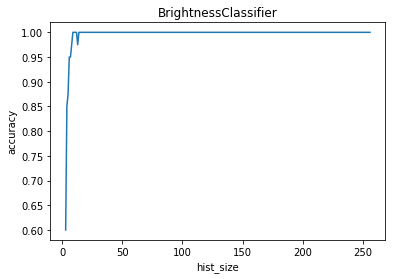

In [526]:
plt.plot(range(3, 257), accuracies)
plt.xlabel('hist_size')
plt.ylabel('accuracy')
plt.title('BrightnessClassifier');

In [528]:
print('Оптимальный параметр size:', np.arange(3, 257, 1)[np.argmax(accuracies)])
print('Точность:', max(accuracies))

Оптимальный параметр size: 9
Точность: 1.0


## Дискретное преобразование Фурье

**Классификация с параметром по умолчанию `size=1.0`**

In [517]:
dft_clf = DFTClassifier()

In [518]:
dft_clf.fit(X_train, y_train)

In [519]:
%%time
y_pred = dft_clf.predict(X_test)

CPU times: user 1.66 s, sys: 1.8 s, total: 3.46 s
Wall time: 904 ms


In [520]:
accuracy_score(y_pred, y_test)

0.975

**Клссификация с параметром `size` в диапазоне [0.1..1.0]**

In [521]:
%%time
accuracies = []
for size in np.arange(0.1, 1.05, 0.05):
    dft_clf = DFTClassifier(size=size)
    dft_clf.fit(X_train, y_train)
    y_pred = dft_clf.predict(X_test)
    accuracies.append(accuracy_score(y_pred, y_test))

CPU times: user 15.9 s, sys: 2.9 s, total: 18.8 s
Wall time: 15.2 s


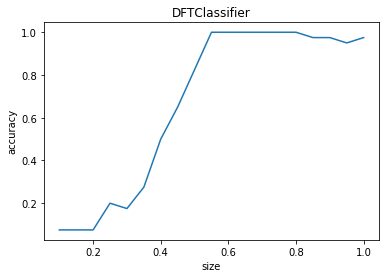

In [522]:
plt.plot(np.arange(0.1, 1.05, 0.05), accuracies)
plt.xlabel('size')
plt.ylabel('accuracy')
plt.title('DFTClassifier');

In [524]:
print('Оптимальный параметр size:', np.arange(0.1, 1.05, 0.05)[np.argmax(accuracies)])
print('Точность:', max(accuracies))

Оптимальный параметр size: 0.5500000000000002
Точность: 1.0


## Дискретное косинусное преобразование

**Классификация с параметром по умолчанию `size=1.0`**

In [449]:
dct_clf = DCTClassifier()

In [450]:
dct_clf.fit(X_train, y_train)

In [451]:
%%time
y_pred = dct_clf.predict(X_test)

CPU times: user 936 ms, sys: 1.19 s, total: 2.12 s
Wall time: 557 ms


In [452]:
accuracy_score(y_pred, y_test)

0.975

**Клссификация с параметром `size` в диапазоне [0.1..1.0]**

In [529]:
%%time
accuracies = []
for size in np.arange(0.1, 1.05, 0.05):
    dct_clf = DCTClassifier(size=size)
    dct_clf.fit(X_train, y_train)
    y_pred = dct_clf.predict(X_test)
    accuracies.append(accuracy_score(y_pred, y_test))

CPU times: user 8.68 s, sys: 1.06 s, total: 9.74 s
Wall time: 8.26 s


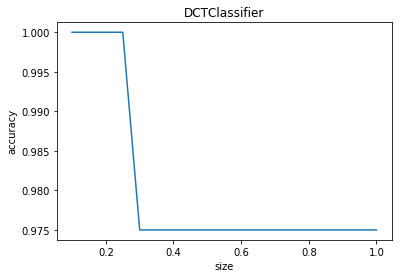

In [530]:
plt.plot(np.arange(0.1, 1.05, 0.05), accuracies)
plt.xlabel('size')
plt.ylabel('accuracy')
plt.title('DCTClassifier');

In [531]:
print('Оптимальный параметр size:', np.arange(0.1, 1.05, 0.05)[np.argmax(accuracies)])
print('Точность:', max(accuracies))

Оптимальный параметр size: 0.1
Точность: 1.0


## Масштабирование

In [483]:
scale_clf = ScaleClassifier(sizes=[0.1, 0.5, 0.8])

In [484]:
%%time
scale_clf.fit(X_train, y_train)

CPU times: user 1.74 s, sys: 1.61 s, total: 3.35 s
Wall time: 1.15 s


In [485]:
%%time
y_pred = scale_clf.predict(X_test)

CPU times: user 1.18 s, sys: 1.13 s, total: 2.31 s
Wall time: 796 ms


In [486]:
accuracy_score(y_pred, y_test)

0.975

**Классификация с параметром `sizes` в диапазоне [0.05..1.0]**

In [487]:
%%time
accuracies = []
for size in np.arange(0.05, 1.05, 0.05):
    scale_clf = ScaleClassifier(sizes=[size])
    scale_clf.fit(X_train, y_train)
    y_pred = scale_clf.predict(X_test)
    accuracies.append(accuracy_score(y_pred, y_test))

CPU times: user 24.3 s, sys: 22.5 s, total: 46.8 s
Wall time: 15.8 s


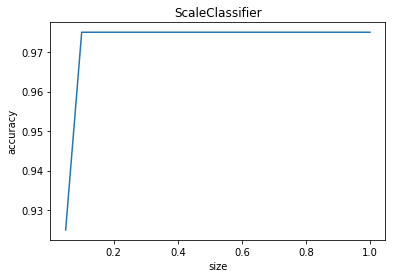

In [488]:
plt.plot(np.arange(0.05, 1.05, 0.05), accuracies)
plt.xlabel('size')
plt.ylabel('accuracy')
plt.title('ScaleClassifier');

**Классификация с параметром `sizes` в диапазоне [0.05..1.0].    
Предыдущие параметры на каждой итерации не удаляются**

In [489]:
%%time
accuracies = []
sizes = []
for size in np.arange(0.05, 1.05, 0.05):
    sizes.append(size)
    scale_clf = ScaleClassifier(sizes=sizes)
    scale_clf.fit(X_train, y_train)
    y_pred = scale_clf.predict(X_test)
    accuracies.append(accuracy_score(y_pred, y_test))

CPU times: user 3min 22s, sys: 3min 18s, total: 6min 40s
Wall time: 2min 19s


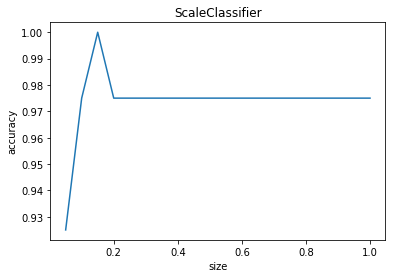

In [492]:
plt.plot(np.arange(0.05, 1.05, 0.05), accuracies)
plt.xlabel('size')
plt.ylabel('accuracy')
plt.title('ScaleClassifier');

In [501]:
print('Оптимальный набор параметров:', sizes[:np.argmax(accuracies) + 1])
print('Точность:', np.max(accuracies))

Оптимальный набор параметров: [0.05, 0.1, 0.15000000000000002]
Точность: 1.0


## Градиент

**Классификация с параметром по умолчанию `ksize=-1`.    
В этом случае используется `3x3 Scharr` фильтер.**

In [502]:
gradient_clf = GradientClassifier()

In [503]:
gradient_clf.fit(X_train, y_train)

In [504]:
%%time
y_pred = gradient_clf.predict(X_test)

CPU times: user 1.14 s, sys: 1.33 s, total: 2.48 s
Wall time: 721 ms


In [505]:
accuracy_score(y_pred, y_test)

0.65

**Классификация с параметром `ksize` в диапазоне [3..31] с шагом 2** 

In [512]:
%%time
accuracies = []
for ksize in range(3, 31 + 1, 2):
    gradient_clf = GradientClassifier(ksize=ksize)
    gradient_clf.fit(X_train, y_train)
    y_pred = gradient_clf.predict(X_test)
    accuracies.append(accuracy_score(y_pred, y_test))

CPU times: user 19.9 s, sys: 21.6 s, total: 41.5 s
Wall time: 12.9 s


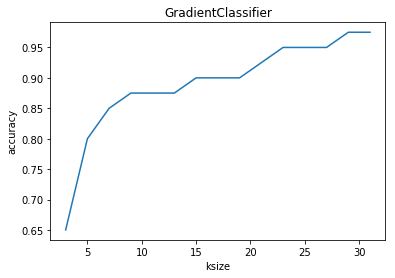

In [513]:
plt.plot(range(3, 31 + 1, 2), accuracies)
plt.xlabel('ksize')
plt.ylabel('accuracy')
plt.title('GradientClassifier');

In [515]:
print('Оптимальный параметр ksize:', list(range(3, 32, 2))[np.argmax(accuracies)])
print('Точность:', max(accuracies))

Оптимальный параметр ksize: 29
Точность: 0.975
